In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.offline import plot
pio.renderers.default = "svg"

In [2]:
df = pd.read_csv('covid_19_data.csv')
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


Data Preprocessing and Cleaning
=

In [3]:
df.rename(columns = {"Country/Region": "Country", "ObservationDate": "Date"}, inplace = True)
df["Country"].replace({"Mainland China": "China"}, inplace = True)

#dropping unwanted columns
df = df.drop(columns = ["SNo", "Province/State", "Last Update"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172480 entries, 0 to 172479
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date       172480 non-null  object 
 1   Country    172480 non-null  object 
 2   Confirmed  172480 non-null  float64
 3   Deaths     172480 non-null  float64
 4   Recovered  172480 non-null  float64
dtypes: float64(3), object(2)
memory usage: 6.6+ MB


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.Country.unique()

array(['China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan', 'Thailand',
       'South Korea', 'Singapore', 'Philippines', 'Malaysia', 'Vietnam',
       'Australia', 'Mexico', 'Brazil', 'Colombia', 'France', 'Nepal',
       'Canada', 'Cambodia', 'Sri Lanka', 'Ivory Coast', 'Germany',
       'Finland', 'United Arab Emirates', 'India', 'Italy', 'UK',
       'Russia', 'Sweden', 'Spain', 'Belgium', 'Others', 'Egypt', 'Iran',
       'Israel', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan', 'Bahrain',
       'Kuwait', 'Austria', 'Algeria', 'Croatia', 'Switzerland',
       'Pakistan', 'Georgia', 'Greece', 'North Macedonia', 'Norway',
       'Romania', 'Denmark', 'Estonia', 'Netherlands', 'San Marino',
       ' Azerbaijan', 'Belarus', 'Iceland', 'Lithuania', 'New Zealand',
       'Nigeria', 'North Ireland', 'Ireland', 'Luxembourg', 'Monaco',
       'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic', 'Armenia',
       'Dominican Republic', 'Indonesia', 'Portugal', 'Andorra', 'Latvia',
       'Moroc

In [5]:
df["Country"].replace({"('St. Martin',)": 'St. Martin'}, inplace = True)

#seperating datasets for each kind of stat
confirmed = df.groupby(['Date'])['Confirmed'].sum().reset_index()
deaths = df.groupby(['Date'])['Deaths'].sum().reset_index()
recovered = df.groupby(['Date'])['Recovered'].sum().reset_index()

Visualization of Cases, Deaths and Recovery over time
=

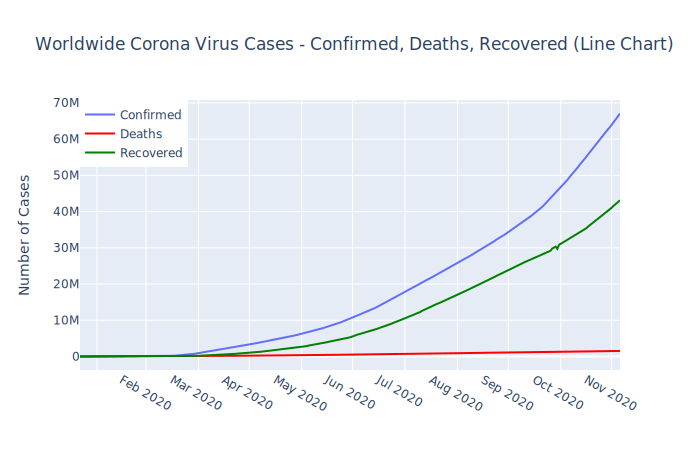

In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=confirmed['Date'], 
                         y=confirmed['Confirmed'],
                         mode='lines',
                         name='Confirmed'
                        ))
fig.add_trace(go.Scatter(x=deaths['Date'], 
                         y=deaths['Deaths'],
                         mode='lines',
                         name='Deaths',
                         line=dict(color='Red')
                        ))
fig.add_trace(go.Scatter(x=recovered['Date'], 
                         y=recovered['Recovered'],
                         mode='lines',
                         name='Recovered',
                         line=dict(color='Green')
                        ))
fig.update_layout(
    title='Worldwide Corona Virus Cases - Confirmed, Deaths, Recovered (Line Chart)',
    yaxis=dict(title='Number of Cases'),
    legend=dict(x=0, y=1.0)
)
fig.update_xaxes(
    dtick="M1",
    ticklabelmode="period"
)
fig.show()

Preparing Data for plotting Daily New Cases Globally
=
By subtracting confirmed cases a day earlier from respective day's number of confirmed cases

In [7]:
df2 = df.groupby('Date').sum().reset_index()
df2.head()

,Date,Confirmed,Deaths,Recovered
0,2020-01-22,555.0,17.0,28.0
1,2020-01-23,653.0,18.0,30.0
2,2020-01-24,941.0,26.0,36.0
3,2020-01-25,1438.0,42.0,39.0
4,2020-01-26,2118.0,56.0,52.0


In [8]:
#initializing numpy array to store daily change
new_cases = np.zeros(len(df2.Date))
for i, row in df2.iterrows():
    if i!=0:
        new_cases[i] = row.Confirmed - df2.iloc[i-1].Confirmed

#storing array as a new df column
df2["new_cases"] = new_cases
df2.head()

,Date,Confirmed,Deaths,Recovered,new_cases
0,2020-01-22,555.0,17.0,28.0,0.0
1,2020-01-23,653.0,18.0,30.0,98.0
2,2020-01-24,941.0,26.0,36.0,288.0
3,2020-01-25,1438.0,42.0,39.0,497.0
4,2020-01-26,2118.0,56.0,52.0,680.0


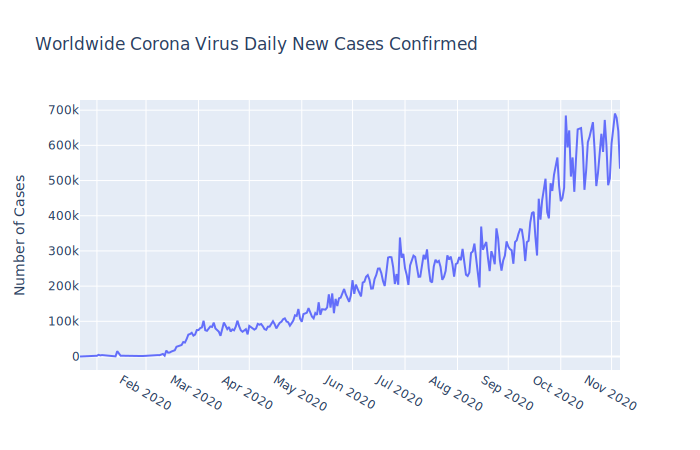

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df2['Date'], 
                         y=df2['new_cases'],
                         mode='lines',
                         name='Daily New Cases'
                        ))
fig.update_layout(
    title='Worldwide Corona Virus Daily New Cases Confirmed',
    yaxis=dict(title='Number of Cases'),
    legend=dict(x=0, y=1.0)
)
fig.update_xaxes(
    dtick="M1",
    ticklabelmode="period"
)
fig.show()

# Plots Country-wise
### Cases, Deaths, Recovery and Recovery Rate

In [10]:
country_wise = df.groupby('Country').sum().reset_index()

#numpy array for storing percentage of recovery per country
rec_rate = np.zeros(len(country_wise.Country))
for i, row in country_wise.iterrows():
    rec_rate[i] = 100*row.Recovered/row.Confirmed

country_wise["Recovery Rate"] = rec_rate    
country_wise.head()

,Country,Confirmed,Deaths,Recovered,Recovery Rate
0,Azerbaijan,1.0,0.0,0.0,0.000000
1,Afghanistan,7244619.0,246059.0,5014275.0,69.213785
2,Albania,2432707.0,61695.0,1304302.0,53.615252
3,Algeria,8216852.0,311474.0,5574987.0,67.848210
4,Andorra,494253.0,13476.0,380098.0,76.903529


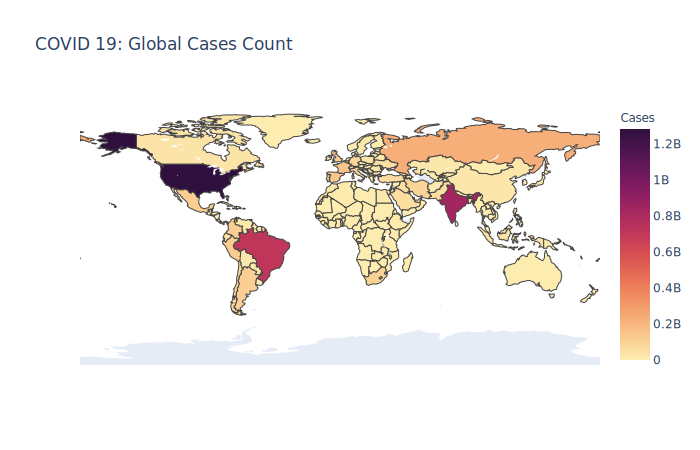

In [11]:
fig_cases = go.Figure(data = go.Choropleth(locations = country_wise['Country'],
                                     z = country_wise['Confirmed'],
                                     locationmode = 'country names',
                                     colorscale = 'matter',
                                     colorbar_title = "Cases"))

fig_cases.update_layout(title_text = 'COVID 19: Global Cases Count',
                  geo = dict(showframe = False,
                           showcoastlines = False,
                           projection_type = 'equirectangular'))
fig_cases.show()

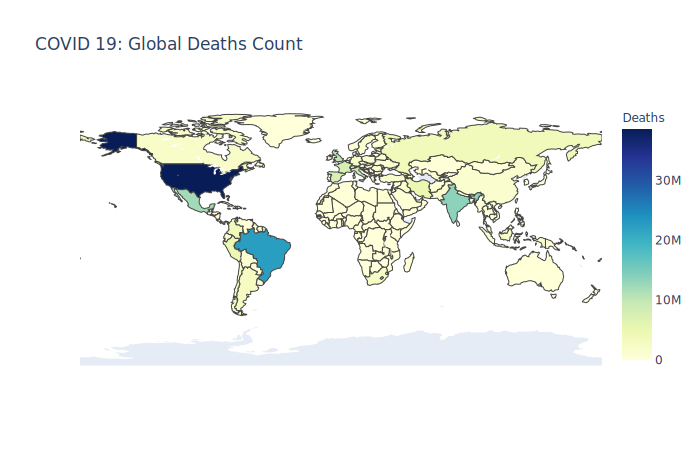

In [12]:
fig_deaths = go.Figure(data = go.Choropleth(locations = country_wise['Country'],
                                     z = country_wise['Deaths'],
                                     locationmode = 'country names',
                                     colorscale = 'ylgnbu',
                                     colorbar_title = "Deaths"))

fig_deaths.update_layout(title_text = 'COVID 19: Global Deaths Count',
                  geo = dict(showframe = False,
                           showcoastlines = False,
                           projection_type = 'equirectangular'))
fig_deaths.show()

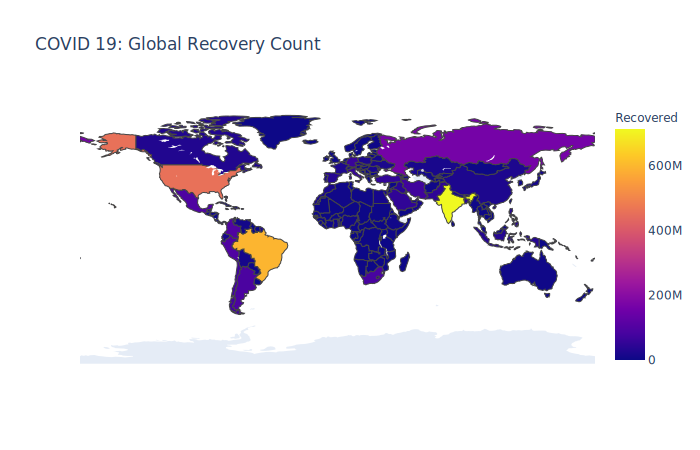

In [13]:
fig_recovered = go.Figure(data = go.Choropleth(locations = country_wise['Country'],
                                     z = country_wise['Recovered'],
                                     locationmode = 'country names',
                                     colorbar_title = "Recovered"))

fig_recovered.update_layout(title_text = 'COVID 19: Global Recovery Count',
                  geo = dict(showframe = False,
                           showcoastlines = False,
                           projection_type = 'equirectangular'))
fig_recovered.show()

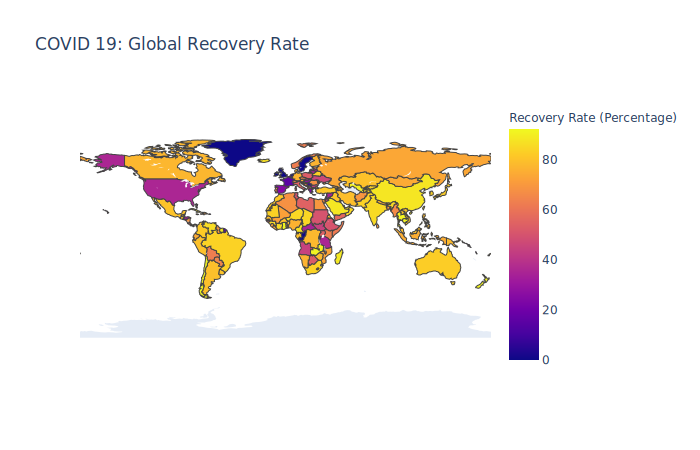

In [14]:
fig_rate = go.Figure(data = go.Choropleth(locations = country_wise['Country'],
                                     z = country_wise['Recovery Rate'],
                                     locationmode = 'country names',
                                     colorbar_title = "Recovery Rate (Percentage)"))

fig_rate.update_layout(title_text = 'COVID 19: Global Recovery Rate',
                  geo = dict(showframe = False,
                           showcoastlines = False,
                           projection_type = 'equirectangular'))
fig_rate.show()

# Interactive Plot for cases per Country by Month
Slider enables you to see the situation by months 

In [15]:
date_country_wise = df.groupby(['Date', 'Country'])[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()
date_country_wise.replace(to_replace=0.0, value=np.nan, inplace = True)
date_country_wise['Date'] = date_country_wise['Date'].dt.to_period('M')
date_country_wise['Date'] = date_country_wise['Date'].astype(str)
date_country_wise.head()

,Date,Country,Confirmed,Deaths,Recovered
0,2020-01,China,547.0,17.0,28.0
1,2020-01,Hong Kong,NaN,NaN,NaN
2,2020-01,Japan,2.0,NaN,NaN
3,2020-01,Macau,1.0,NaN,NaN
4,2020-01,South Korea,1.0,NaN,NaN


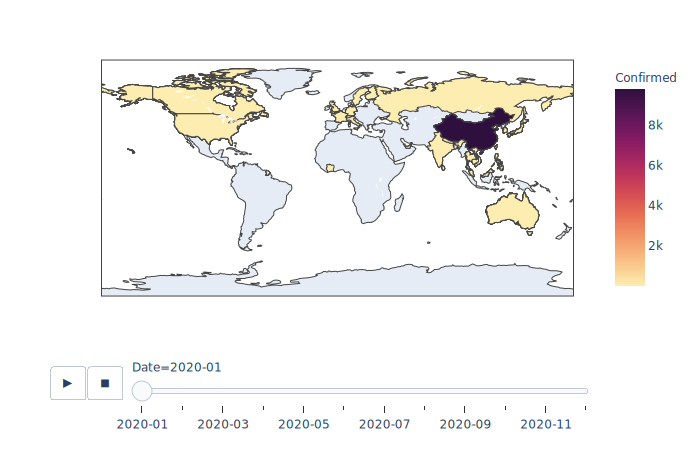

In [16]:
figpx = px.choropleth(data_frame = date_country_wise,
                    locations= "Country",
                    locationmode = 'country names',
                    color= "Confirmed",
                    hover_name= "Country",
                    color_continuous_scale= 'matter',
                    animation_frame= "Date")

figpx.show()